# Fellowship ai Sentiment Analysis Challenge with the Yelp Polarity dataset

__Yelp Review Polarity Dataset__

Version 1, Updated 09/09/2015

ORIGIN

The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge

The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 2 columns in them, corresponding to class index (1 and 2) and review text. The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".



In [1]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from fastai.metrics import accuracy
from fastai.text import *
from fastai import *

In [2]:
def read_in_data(df_names, directory = './'):
    '''Read in data into seperate dataframes'''
    
    # change directory to data storage location
    os.chdir(directory)
    
    # list of filenames
    extension = 'csv'
    filenames = [i for i in glob.glob('*.{}'.format(extension))]
    
    # create global dfs within function
    for name, file in zip(df_names, filenames):
        globals()[name] = pd.read_csv(file, header=None, names = ['sentiment', 'text'])

In [3]:
# list of prefered dataframe names in same order as directory
df_names = ['test', 'train']
directory = '/Users/mattmerrill/Springboard/fellowship-ai_challenge/data'

read_in_data(df_names, directory)

In [4]:
train.head()

,,,sentiment,text
NaN,sentiment,text,clean_text,review_len
15488.0,1,"We stay at Mandalay each year for an annual golf tournament, so MIX lounge is conveniently upstairs. Its definitely not a club like the others along the strip... Just a chill place to grab drinks. The dance floor is small, and pretty much non-existent. The crowd is older... No young hotties. The DJ wasn't that great the last time I was there either.. He didn't know how to transition songs! But the view is great though... Cant get a better view of the strip than from MIX! They also have an open-air balcony if you wanna get some fresh air...",we stay at mandalay each year for an annual go...,545
29491.0,2,"Best breakfast in Scottsdale! Omg! I had a whole hog skillet with scrambled cheese eggs, my brother had the same with a sunny side egg. My sister had wild berry bliss toast. Also ordered the biscuits and gravy with a side of cheese grits. Ordered so much to sample due to the amazing delicious looking images provided by Yelpers. We spent about 65 bucks including tip. Well worth it.",best breakfast in scottsdale omg i had a whole...,383
14338.0,1,"Poor Customer Service! I visit this location fairly often but tonight was the worst! Marvin, the manager took my order, and got it wrong. When I explained to him it wasn't what I ordered nor was it what he repeated back he basically shrugged his shoulders and said oh well. He did nothing to rectify the issue, not even a simple apology which I would have gladly accepted as mistakes happen. I asked for the corporate number and he said its on the website. I jumped right on the website to a \""contact us\"" form. Site stated the business hours are from 8a-5p and it may take 96 hours to respond as the personally respond to all messages. Approximately 10 minutes after I hit submit, I get this generic email stating we're sorry you're not pleased! I'm not buying it at all. I enjoy wingstop but I will not be returning. Throughout my years in customer service I've learned customers will tolerate a lot but poor service isn't one of them!",poor customer service i visit this location fa...,938
29485.0,2,"It's tough to review this place. I once got the Norwegian Burger and never looked back. It is the only thing I order there. I have cravings for it. I can't even tell you what else is on the menu. The beef is not as flavorful as some other places like Clover Joes a few place down, but everything else they throw on it still makes this one of the best in my opinion.\nMaybe one day I'll branch out. It just doesn't seem like I need to.",its tough to review this place i once got the ...,434


In [5]:
test.head()

,,,sentiment,text
NaN,sentiment,text,clean_text,review_len
25789.0,2,Super awesome friendly staff! I always want to try something different but end up getting the New Yorker because it is awesome!,super awesome friendly staff i always want to ...,127
22878.0,2,"Simple, laid back & very casual.\n\nCopper is the best beer!! Food is good and service is quick. Plus they have FREE Yoga on Tuesday nights started by LuLuLemon. What could be better than yoga and beer??\n\nBest tip about this place: they have \""OMB coins\"" that you use like money - as if you're a leprechaun or 10yrs old in an arcade - so fun!!",simple laid back very casualnncopper is the be...,346
2065.0,1,"Service has changed at this store over the years, good luck checking out in any reasonable length of time. Be sure the charges are correct too, while you are at it.\nWhen shopping here, the system is clearly designed to keep you in the store longer. It is more difficult than necessary to find a specific book, as subject matter is spread over several small sections in various aisles rather than in one place. I get the idea of wanting people to linger, but it is so chaotic to find anything that, in my case, it has the opposite effect. There are a lot of books though, will give you that.\nTheir buy program is worse than any of the other bookstores. Less than 5 percent of their half price resale, not the original price. Insulting. Worst offers include a $40 brand new release hardbound for 50 cents, hardbound new release still in the plastic for 75 cents, and so on. Save your books and sell at a garage sale, seriously!\n \nI've been a frequent shopper at bookstores in many cities, this one scores at the bottom for overall experience. Any mom and pop is better.",service has changed at this store over the yea...,1081
33417.0,2,"Reasons why I love Vegas... Places like THIS.\n\nIt was 1am (no I wasn't drunk...so my star rating is not under the influence of alcohol on this occasion)\n\nWe were just tired after a long drive in from Phoenix and starving. We stopped in and were greeted by friendly service, and delicious entrees. \n\nPrices VERY reasonable, and the cuisine was solid. Fresh ingredients (except for the spring rolls which tasted like they were from a box...hence the 4 stars instead of 5)\n\nEven at 1am, I felt like they cared just as much about our business as they do at the busiest dinner crowd times. I will definitely come back here again!",reasons why i love vegas places like thisnnit ...,632


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30401 entries, (nan, sentiment, text) to (5994.0, 1, Read all the reviews before going so I was a little skeptical but thought I would try anyway. Cute little place, seated right away which was good for a Saturday at 1230. Ordered eggs Benedict but they had sold out! A breakfast place that runs out of breakfast food, hum. Got the breakfast sandwich which came out cut in half, on a large white plate with no garnish. Had to ask for silverware and napkins. Service was ok, sandwich average.)
Data columns (total 2 columns):
sentiment    30401 non-null object
text         30401 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7601 entries, (nan, sentiment, text) to (32943.0, 1, Let me start by saying I only went here because the girl I usually go to lives far so I decided to try this place out with their groupon, natural set with retouch. The few times I called nobody even answered, I had to call like 3 times for some rude receptionist to finally answer, apparently it's because they're so \"booked and busy.\" 3 weeks later (yea I said 3 weeks) it's finally time for my appt, I get there it's nice clean and fancy, the receptionist seems to be nicer in person than phone, the girl that did my eyelashes must have been new, let me tell you... it took a whole 2 and a half hours to do my natural set! Some asian lady had to come in towards the end to finish it off and make it go faster! I get eyelashes done all the time and a dramatic set by my girl only takes 45 minutes! Anyway 2 weeks later I had my retouch appt, and I couldn't make it I was called into work and as

## Fellowship ai Challenge Description

Perform Sentiment analysis using ULMFiT on Yelp reviews - Polarity and apply the EDA augmentation. Report the performance metrics for before and after augmentation? show examples of data augmentaion?

## Exploratory Analysis

Before processing with ULMFiT let's perform some expoloratory analysis to find out most common words, in the process we will also clean the text of urls and lower the case of all words to avoid unnecessary repeats. 

In [8]:
import itertools
import collections

import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [9]:
all_reviews = [text for text in train.text]

In [10]:
all_reviews[:2]

['review_len', '545']

In [11]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [12]:
all_reviews_no_urls = [remove_url(text) for text in all_reviews]
all_reviews_no_urls[:2]

['reviewlen', '545']

In [13]:
# Create a list of lists containing lowercase words for each tweet
words_in_review = [review.lower().split() for review in all_reviews_no_urls]
all_reviews_lower = [review.lower() for review in all_reviews_no_urls]

In [14]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_review))

In [15]:
# Collections library for python includes the counter function, which we will use here to count the frequency of words
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls.most_common(15)

[('196', 55),
 ('241', 51),
 ('320', 48),
 ('272', 47),
 ('285', 47),
 ('270', 46),
 ('354', 46),
 ('254', 46),
 ('231', 45),
 ('178', 45),
 ('276', 45),
 ('337', 45),
 ('313', 45),
 ('189', 44),
 ('319', 44)]

> Let's remove the stop words and analyze the top words again. This may give us more insight into the text.

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattmerrill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
stop_words = set(stopwords.words('english'))

In [18]:
# Remove stop words from each review list of words
reviews_nsw = [[word for word in review_words if not word in stop_words]
              for review_words in words_in_review]

In [19]:
# let's take a look again at the most common words
all_words_nsw = list(itertools.chain(*reviews_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('196', 55),
 ('241', 51),
 ('320', 48),
 ('272', 47),
 ('285', 47),
 ('270', 46),
 ('354', 46),
 ('254', 46),
 ('231', 45),
 ('178', 45),
 ('276', 45),
 ('337', 45),
 ('313', 45),
 ('189', 44),
 ('319', 44)]

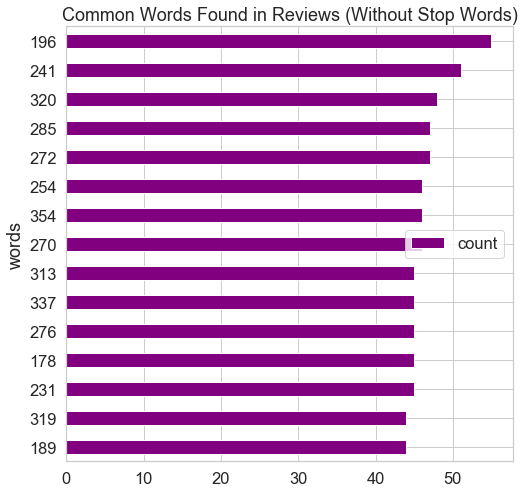

In [20]:
clean_reviews_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_reviews_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Reviews (Without Stop Words)")

plt.show()

In [21]:
all_reviews_lower[:2]

['reviewlen', '545']

In [22]:
train['clean_text'] = all_reviews_lower

In [23]:
train_unprocessed = train[['sentiment', 'text']]
train_processed = train[['sentiment', 'clean_text']]

## Machine Learning

In [24]:
from sklearn.model_selection import train_test_split

# Split into training and test
train_raw, test_raw = train_test_split(train_unprocessed,test_size=0.2,random_state=3)
train_clean, test_clean = train_test_split(train_processed,test_size=0.2,random_state=3)

In [25]:
train_raw.to_csv('train_raw.csv', index=0)
test_raw.to_csv('test_raw.csv', index=0)
train_clean.to_csv('train_clean.csv', index=0)
test_clean.to_csv('test_clean.csv', index=0)

In [26]:
df = pd.read_csv('train_raw.csv').reset_index(drop=True)

In [30]:
from fastai.text import data
dls = data.TextDataLoaders.from_df(df, path='', text_col='text', is_lm=True, label_col='sentiment')

AttributeError: module 'fastai.text.data' has no attribute 'TextDataLoaders'

In [ ]:
from fastai.text import learner
learn = learner.language_model_learner(dls, AWD_LSTM, drop_mult=0.3)

In [82]:
conda install fastai -c fastai -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /Users/mattmerrill/opt/anaconda3

  added / updated specs:
    - fastai


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dataclasses-0.7            |           py37_0           9 KB
    fastai-1.0.61              |                1         177 KB  fastai
    nvidia-ml-py3-7.352.0      |             py_0          22 KB  fastai
    ------------------------------------------------------------
                                           Total:         207 KB

The following NEW packages will be INSTALLED:

  dataclasses        pkgs/main/osx-64::dataclasses-0.7-py37_0
  nvidia-ml-py3      fastai/noarch::nvidia-ml-py3-7.352.0-py_0

The following packages will be DOWNGRADED:

  fastai                                         2.1.5-py_0 --> 1.0.61-1



nvidia-ml-py3-7.352. | 22 KB     | ##################################### | 1

In [31]:
import fastai; fastai.__version__

'1.0.61'

In [32]:
import fastai; fastai.__version__

'1.0.61'